In [1]:
import sys
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import Delaunay
from scipy.optimize import curve_fit
from skimage.measure import regionprops

sys.path.append("analysis/utils")
import vm_output_handling as vm_output

In [15]:
# load dataset s
datasets = ["holomonitor_20240301_B1-4",
            "holomonitor_20240301_B2-2",
            "holomonitor_20240317_B1-1",
            "holomonitor_20240516_A2-1",
            "holomonitor_20240516_B1-22"]

bond_breaking = []
densities = []

for dataset in datasets: 
    bond_breaking.append(np.load(f"../MDCK_QPI/data/experimental/processed/{dataset}/bond_breaking_correlation.npy"))
    densities.append(np.load(f"../MDCK_QPI/data/experimental/processed/{dataset}/densities.npy"))

In [16]:
# restructure
Cb = []

for i in range(len(datasets)):
    for j in range(len(bond_breaking[i])):
        Cb.append((bond_breaking[i][j][bond_breaking[i][j] > 0], int(densities[i][j])))

Cb_sorted = sorted(Cb, key=lambda x: x[1])

Nframes = np.max([len(bond) for bond in bond_breaking])
Ndata = len(Cb_sorted)
Cb = np.zeros([Ndata, Nframes])
rho = np.zeros(Ndata)

for i in range(len(Cb_sorted)):
    j = len(Cb_sorted[i][0])
    Cb[i, :j] = Cb_sorted[i][0]
    rho[i] = Cb_sorted[i][1]


Cb = np.ma.array(Cb, mask=Cb==0)

In [17]:
drho = 200
rho_min = 1400
rho_max = 2600
Nrho = int((rho_max - rho_min) / drho)

C_binned = np.ma.zeros([Nrho, Nframes])

for i in range(Nrho):
    mask = (rho > rho_min + i*drho) * (rho < rho_min + (i+1)*drho)
    C_binned[i] = np.ma.mean(Cb[mask], axis=0)

In [18]:
def decay(t, tau, const):
    return const * np.exp(- t / tau)

/tmp/ipykernel_8498/4175312996.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


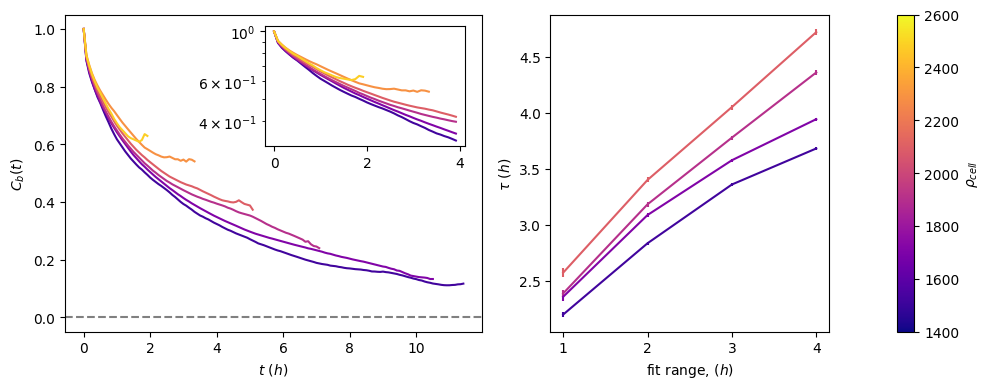

In [19]:
cmap   = mpl.colormaps['plasma']
colors = cmap(np.linspace(0.1, 0.9, Nrho))
sm     = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=rho_min, vmax=rho_max))

frames = np.arange(Nframes) * 1/12
rho = np.arange(rho_min, rho_max, drho)

fig, ax = plt.subplots(1,3, figsize=(10,4), width_ratios=[0.6, 0.4, 0.025])
ax[0].axhline(0, ls="dashed", color="gray")
ax[0].set(ylabel=r"$C_b(t)$", xlabel=r"$t~(h)$")
ax[1].set(xlabel=r"fit range, $(h)$", ylabel=r"$\tau ~(h)$")


left, bottom, width, height = [0.27, 0.62, 0.2, 0.3]
ax_log = fig.add_axes([left, bottom, width, height])

for i in range(Nrho):

    ax[0].plot(frames, C_binned[i], color=colors[i])
    ax_log.plot(frames[:4*12], C_binned[i][:4*12], color=colors[i])

ax_log.set(yscale="log")


for i in range(Nrho-2):
    tau = []
    stau = []

    for j in range(1,5):
        # fit
        param, pcov = curve_fit(decay, frames[:12*j], C_binned[i][:12*j])
        tau.append(param[0])
        stau.append(pcov[0,0])
        
    ax[1].errorbar(np.arange(1,5), tau, yerr=stau, fmt='-', color=colors[i])

# fig.subplots_adjust(right=0.6)
# cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.7])

fig.colorbar(sm, cax=ax[2], label=r"$\rho_{cell}$")
fig.tight_layout()
fig.savefig("Experimental_bond_breaking_correlation.png", dpi=300)

In [3]:
bond_breaking = np.load("bond_breaking_correlation.npy")

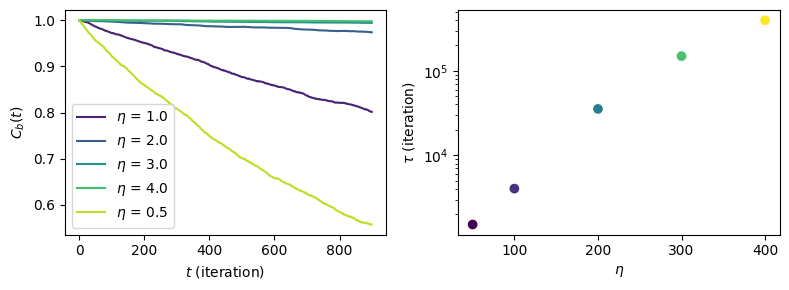

In [13]:
cmap   = mpl.colormaps['viridis']
colors = cmap(np.linspace(0.1, 0.9, len(bond_breaking)))
# sm     = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=rho_min, vmax=rho_max))


frames = np.arange(len(bond_breaking[0]))
tau = []
stau = []
eta = [100, 200, 300, 400, 50]

fig, ax = plt.subplots(1,2, figsize=(8,3))

for i in range(len(bond_breaking)):
    ax[0].plot(frames, bond_breaking[i]/10, c=colors[i], label=rf"$\eta$ = {eta[i]/100:0.1f}")
    param, pcov = curve_fit(decay, frames, bond_breaking[i]/10)
    tau.append(param[0])
    stau.append(pcov[0,0])

ax[0].set(xlabel=r"$t$ (iteration)", ylabel=r"$C_b(t)$",  yscale="linear")
ax[1].set(xlabel=r"$\eta$", ylabel=r"$\tau$ (iteration)", yscale="log")
ax[1].scatter(eta, tau, c=eta)
ax[0].legend()

fig.tight_layout()
fig.savefig("Simulation_bon_breaking_correlation.png", dpi=300)

In [17]:
def self_intermediate_scattering_function_radial(x, y, q, t_max=None):
    # Number of particles
    N = x.shape[1]  # number of columns
        
    # Maximum time if not specified
    if t_max is None:
        t_max = x.shape[0]  # number of rows
    
    # Initialize SISF array
    SISF = np.zeros(t_max)
    
    # Loop over time
    for t in range(t_max):

        # Compute the radial distance for each particle
        dx = x[t, :] - x[0, :]  # displacement in x
        dy = y[t, :] - y[0, :]  # displacement in y
        dr = np.sqrt(dx**2 + dy**2)
        
        # Calculate the SISF using the average of exp(i * q * r)
        # Assume q is a scalar radial distance (magnitude)
        exp_term = np.exp(1j * q * dr)
        
        # Calculate the average
        SISF[t] = np.real(np.sum(exp_term)) / N
    
    return SISF


In [29]:
list_vm, _ = vm_output.load("nodivision_20251023_N30_L64_Lambda50_v0100_taup100_eta100.p")
cell_positions = vm_output.get_cell_positions(list_vm)

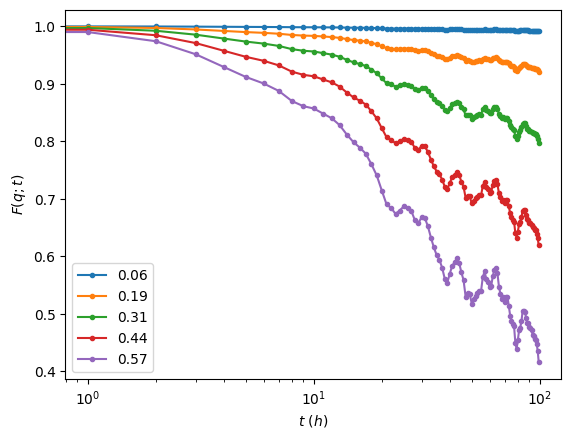

In [32]:
q_arr = [0.06, 0.13, 0.19, 0.25, 0.31, 0.38, 0.44, 0.50, 0.57, 0.63]

for q in q_arr[0:-1:2]:

    #q = i*2*np.pi / N #[i*2*np.pi / N, i*2*np.pi / N]
    sisf_t = self_intermediate_scattering_function_radial(cell_positions[:,:,0], cell_positions[:,:,1], q)
    plt.plot(sisf_t, '.-', label=f"{q:0.2f}")

    #sisf_t = self_intermediate_scattering_function(cellprop.x, cellprop.y, q)
plt.legend()
plt.legend()
plt.xscale("log")
plt.xlabel(r"$t ~(h)$")
plt.ylabel(r"$F(q;t)$")
plt.savefig(f"results/nodivision_pairdissipation_20251022_N30_L64_Lambda100_v0100_taup300_eta50/self_intermediate_scattering.png", dpi=300)

In [ ]:
dr_arr = np.sqrt(np.diff(cell_positions[:,:,0], axis=0)**2 + np.diff(cell_positions[:,:,1], axis=0)**2)

dr = np.mean(dr_arr)


NameError: name 'cell_positions' is not defined

In [24]:
dr = 0.24

In [27]:
dr_exp = 1.7
dt_exp = 1/12

v_exp = dr_exp / dt_exp # µm / h

r_scale = 7.2
t_scale = (dr / v_exp)*r_scale

v_sim = (dr / 1) * r_scale / t_scale

In [30]:
t_scale

0.08470588235294116